# Initialization

In [2]:
#!/usr/bin/python

__author__ = 'Elliot Simon'
__email__ = 'ellsim@dtu.dk'
__date__ = 'May 9, 2018'
__credits__ = ["DTU-Risø", "NCAR"]

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
import scipy
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
import keras
import tensorflow as tf

In [4]:
print(keras.__version__)
print(tf.__version__)

2.2.0
1.8.0


In [201]:
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Serif'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['savefig.transparent'] = True

In [6]:
%matplotlib inline

# Process input data

## Optical flow (X)

In [7]:
%%time
# Load in optical flow result from other notebook
flows = np.load('.\\temp\\flows.npy')
print(flows.shape)

(201, 394, 2, 3270)
Wall time: 17.7 s


In [8]:
# Reshape to correct input (Time, Y, X, C-features)
input_data = np.moveaxis(flows, -1, 0)
input_shape = input_data.shape
print(input_shape)

(3270, 201, 394, 2)


## Radial speeds directly (X)

In [ ]:
# Load in cartesian transformed lidar scans from other notebook
cart_scans = np.load('Nov14-15_cart_scans.npy')
print(cart_scans.shape)

In [ ]:
# Plot one to check
plt.pcolormesh(cart_scans[:,:,0])

In [ ]:
# Absolute value everything to make speeds positive?
cart_scans = np.abs(cart_scans)

In [ ]:
# Reshape to correct input (Time, Y, X, C-features)
# Last axis is added even though only 1 channel exists
input_data = np.moveaxis(cart_scans, -1, 0)
input_data = input_data.reshape(input_data.shape[0], input_data.shape[1], input_data.shape[2], 1)
input_shape = input_data.shape
print(input_shape)

## Mast data (y)

In [ ]:
# Make some random Y data for initial testing 
#y = np.random.weibull(7, size=(input_shape[0],1))
#print(y.shape)

In [ ]:
# Load mast data and already calculated u,v
# Has been resampled from 50Hz to 1s already
#starttime = '201711141400'
#endtime = '201711150200'
#filename = starttime + "_" + endtime

#df_mast_1s = pd.read_hdf(filename + '_1s.hd5','df')

In [ ]:
# Timestamps already accounted for when prepping data
# Shift timestamp to match windscanner
# 60 minutes for UTC-CET conversion, and 10 minutes to stamping notation
#df_mast_1s = df_mast_1s.shift(freq=pd.Timedelta(minutes=-70))

In [ ]:
# Resample to 13 second periods
#print(df_mast_1s.shape[0]/13)
#df_mast_13s = df_mast_1s.resample('13S').mean()
#df_mast_13s = df_mast_1s.rolling('13S').mean()
#print(df_mast_13s.shape[0])

In [9]:
# Read in already prepared mast-dataset, including already decomposed u & v
df_13s = pd.read_hdf('df_joined_13s_Nov14_15.hdf','df')
print(df_13s.shape)
# Remove last value to match lidar input shape
df_13s = df_13s.iloc[0:-1]
print(df_13s.shape)

(3271, 409)
(3270, 409)


In [109]:
# See what kind of data we have from the mast & turbine
df_13s.columns[0:15]

Index(['ROT', 'pitch', 'ActPow', 'SWsp_70m', 'Sdir_70m', 'SWsp_44m',
       'Sdir_44m', 'SWsp_18m', 'Sdir_18m', 'u_70m', 'u_44m', 'u_18m', 'v_70m',
       'v_44m', 'v_18m'],
      dtype='object')

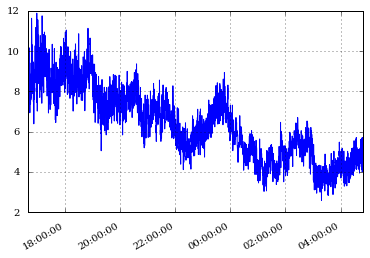

In [117]:
df_13s['SWsp_18m'].plot()

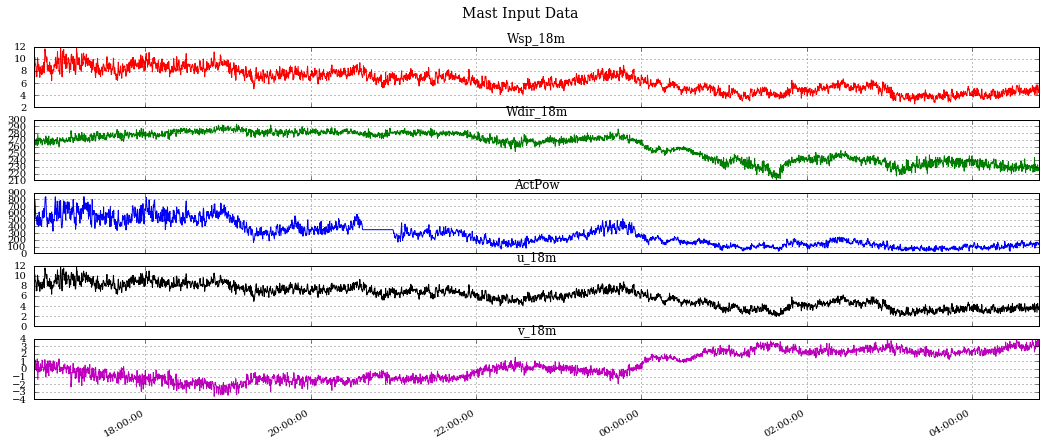

In [10]:
# Inspect time series
f, axarr = plt.subplots(5,1, figsize=(18,7))
axarr[0].plot(df_13s['SWsp_18m'], c='r')
axarr[1].plot(df_13s['Sdir_18m'], c='g')
axarr[2].plot(df_13s['ActPow'], c='b')
axarr[3].plot(df_13s['u_18m'], c='k')
axarr[4].plot(df_13s['v_18m'], c='m')


plt.suptitle('Mast Input Data', fontsize=14)
axarr[0].set_title('Wsp_18m')
axarr[1].set_title('Wdir_18m')
axarr[2].set_title('ActPow')
axarr[3].set_title('u_18m')
axarr[4].set_title('v_18m')
f.autofmt_xdate()

In [13]:
# Format our Y input from the mast data
# 2D, u & v horizontal components
mast_input_data = np.vstack([df_13s['u_18m'], df_13s['v_18m']])
mast_input_data = np.moveaxis(mast_input_data, -1, 0)
print(mast_input_data.shape)

(3270, 2)


In [ ]:
# Format our Y input from the mast data
# 1D, Sonic wind speed 18m
mast_input_data = df_13s['SWsp_18m']
print(mast_input_data.shape)

## Use Lidar Reconstructed Speeds

In [ ]:
#input_data = df_13s.iloc[:,15:212]
print(input_data.shape)

## More pre-processing and checks

In [ ]:
# No scaling
#X = input_data.copy()

## X-Scaling

In [ ]:
# Manually doing this for prototyping, will change to sk-learn functions later in order to reverse

In [136]:
# When X-data is a series of 2D images with 0 and 1 layers (u and v from optical flow)
X = np.empty_like(input_data)
# Standard scaling
#X[:,:,:,0] = (input_data[:,:,:,0] - np.nanmean(input_data[:,:,:,0], axis=None))/np.nanstd(input_data[:,:,:,0], axis=None)
#X[:,:,:,1] = (input_data[:,:,:,1] - np.nanmean(input_data[:,:,:,1], axis=None))/np.nanstd(input_data[:,:,:,1], axis=None)
# Mean subtraction / Range(max-min)
X[:,:,:,0] = (input_data[:,:,:,0] - np.nanmean(input_data[:,:,:,0], axis=None))/(np.nanmax(input_data[:,:,:,0], axis=None) - np.nanmin(input_data[:,:,:,0], axis=None))
X[:,:,:,1] = (input_data[:,:,:,1] - np.nanmean(input_data[:,:,:,1], axis=None))/(np.nanmax(input_data[:,:,:,1], axis=None) - np.nanmin(input_data[:,:,:,1], axis=None))

In [ ]:
# When X-data is a series of flat 2D images (i.e. lidar scans themselves)
X = np.empty_like(input_data)
# Standard scaling
#X[:,:,:,:] = (input_data[:,:,:,:] - np.nanmean(input_data[:,:,:,:], axis=None))/np.nanstd(input_data[:,:,:,:], axis=None)
# Mean subtraction / Range(max-min)
X[:,:,:,:] = (input_data[:,:,:,:] - np.nanmean(input_data[:,:,:,:], axis=None))/(np.nanmax(input_data[:,:,:,:], axis=None) - np.nanmin(input_data[:,:,:,:], axis=None))

## Y-Scaling

In [15]:
# When y-data is 2-D data (time series of u & v)
y = np.empty_like(mast_input_data)
# Standard scaling
#y[:,0] = (mast_input_data[:,0] - np.nanmean(mast_input_data[:,0], axis=None))/np.nanstd(mast_input_data[:,0], axis=None)
#y[:,1] = (mast_input_data[:,1] - np.nanmean(mast_input_data[:,1], axis=None))/np.nanstd(mast_input_data[:,1], axis=None)
# Mean subtraction / Range(max-min)
y[:,0] = (mast_input_data[:,0] - np.nanmean(mast_input_data[:,0], axis=None))/(np.nanmax(mast_input_data[:,0], axis=None) - np.nanmin(mast_input_data[:,0], axis=None))
y[:,1] = (mast_input_data[:,1] - np.nanmean(mast_input_data[:,1], axis=None))/(np.nanmax(mast_input_data[:,1], axis=None) - np.nanmin(mast_input_data[:,1], axis=None))

In [ ]:
# When y-data is 1-D data (wind speed, active power, etc)
# Standard scaling
y = np.empty_like(mast_input_data)
#y = (mast_input_data - np.nanmean(mast_input_data, axis=None))/np.nanstd(mast_input_data, axis=None)
# Mean subtraction / Range(max-min)
y = (mast_input_data - np.nanmean(mast_input_data, axis=None))/(np.nanmax(mast_input_data, axis=None) - np.nanmin(mast_input_data, axis=None))

In [137]:
# Check the mean and variance

print(np.nanmean(X[:,:,:,0]))
print(np.nanvar(X[:,:,:,0]))
print(np.nanmean(X[:,:,:,1]))
print(np.nanvar(X[:,:,:,1]))

#print(np.nanmean(X))
#print(np.nanvar(X))

print(np.nanmean(y[:,0]))
print(np.nanvar(y[:,0]))
print(np.nanmean(y[:,1]))
print(np.nanvar(y[:,1]))

#print(np.nanmean(y))
#print(np.nanvar(y))

-6.020285505545555e-17
0.0026321628839087842
-8.545185330768866e-17
0.0034136810695498602
-1.2168315964087342e-16
0.04242203589752296
0.0
0.05450829732579827


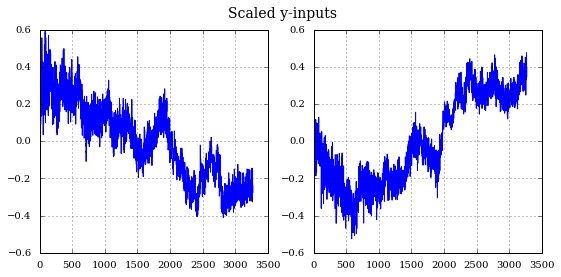

In [16]:
f, axarr = plt.subplots(1,2, figsize=(9,4))
axarr[0].plot(y[:,0])
axarr[1].plot(y[:,1])
plt.suptitle('Scaled y-inputs', fontsize=14);

In [ ]:
plt.plot(y)
plt.title('Scaled y-input')

In [17]:
#Fill NaNs (if they exist) with 0
X = np.nan_to_num(X)
y = np.nan_to_num(y)

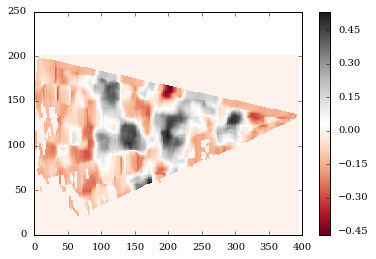

In [133]:
# Check one random scan
plt.pcolormesh(X[100,:,:,0], cmap='RdGy')
plt.colorbar()

# Evaluation functions

In [58]:
# Automated plotting of predictions against y-test

def performance_scatter(y_test, preds):
    f, axarr = plt.subplots(1,2, figsize=(9,4))
    #axarr[0].scatter(y_test[:], preds[:])
    axarr[0].scatter(y_test[:,0], preds[:,0])
    axarr[1].scatter(y_test[:,1], preds[:,1])

    # Adds a line y=x to scatterplot 0
    lims = [
    np.min([axarr[0].get_xlim(), axarr[0].get_ylim()]),  # min of both axes
    np.max([axarr[0].get_xlim(), axarr[0].get_ylim()])]  # max of both axes 
    axarr[0].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axarr[0].set_xlim(lims)
    axarr[0].set_ylim(lims)

    # Adds a line y=x to scatterplot 1
    lims = [
    np.min([axarr[1].get_xlim(), axarr[1].get_ylim()]),  # min of both axes
    np.max([axarr[1].get_xlim(), axarr[1].get_ylim()])]  # max of both axes 
    axarr[1].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axarr[1].set_xlim(lims)
    axarr[1].set_ylim(lims)

    #axarr[0].set_xlim(0,3)
    #axarr[0].set_ylim(0,3)
    #axarr[1].set_xlim(0,3)
    #axarr[1].set_ylim(0,3)
    plt.suptitle('Performance', fontsize=14);

In [59]:
# Plot time series of predictions and reference

def performance_ts(y_test, preds):
    f, axarr = plt.subplots(4,1, figsize=(14,12))
    f.subplots_adjust(hspace=1)
    axarr[0].plot(preds[:,0], c='r')
    axarr[1].plot(y_test[:,0], c='r')
    axarr[2].plot(preds[:,1], c='b')
    axarr[3].plot(y_test[:,1], c='b')

    axarr[0].set_title('Prediction (var 0)')
    axarr[1].set_title('Reference (var 0)')
    axarr[2].set_title('Prediction (var 1)')
    axarr[3].set_title('Reference (var 1)');

In [62]:
# Fit OLS linear model and print out table of results

def ols_fit_summary(x=y_test, y=preds, single_var=False, var_num=0, add_const=True):
    if single_var == True:
        if add_const:
            result = sm.OLS(x,sm.add_constant(y)).fit()
        else:
            result = sm.OLS(x,y).fit()
    else:
        if add_const:
            result = sm.OLS(x[:,var_num],sm.add_constant(y[:,var_num])).fit()
        else:
            result = sm.OLS(x[:,var_num],y[:,var_num]).fit()
    return(result.summary())

def forcast_metrics(x=y_test, y=preds, single_var=False, var_num=0):
    if single_var == True:
        mae = metrics.mean_absolute_error(x, y)
        mse = metrics.mean_squared_error(x, y)
        rmse = np.sqrt(metrics.mean_squared_error(x, y))
    else:
        mae = metrics.mean_absolute_error(x[:,var_num], y[:,var_num])
        mse = metrics.mean_squared_error(x[:,var_num], y[:,var_num])
        rmse = np.sqrt(metrics.mean_squared_error(x[:,var_num], y[:,var_num]))
    return(mae, mse, rmse)



# Model training/prediction

## Pre-processing

In [19]:
from keras.models import Model, save_model, load_model, Sequential
from keras.layers import Reshape, Dense, Activation, Conv2D, Input, AveragePooling2D, MaxPooling2D, MaxPooling3D, Flatten, TimeDistributed, LSTM
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import Callback

In [ ]:
# When testing: sub-select just a small test dataset
X_small = X[0:1000,:,:,:]
y_small = y[0:1000]

In [20]:
# Split up train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.33, random_state=42)

## Conv2D

In [98]:
# Modified from Daivd John Gagne's Swirlflow tutorial: 
# https://github.com/djgagne/swirlnet/blob/master/notebooks/deep_swirl_tutorial.ipynb

# Input data in shape (y, x, variables)
l2_a= 0.001
conv_net_in = Input(shape=X.shape[1:])
# First 2D convolution Layer
conv_net = Conv2D(16, (5, 5), padding="same", kernel_regularizer=l2(l2_a))(conv_net_in)
conv_net = Activation("relu")(conv_net)
conv_net = Dropout(0.1)(conv_net)
# Average pooling takes the mean in a 2x2 neighborhood to reduce the image size
conv_net = AveragePooling2D()(conv_net)
# Second set of convolution and pooling layers
conv_net = Conv2D(32, (5, 5), padding="same", kernel_regularizer=l2(l2_a))(conv_net)
conv_net = Activation("relu")(conv_net)
conv_net = Dropout(0.1)(conv_net)
conv_net = AveragePooling2D()(conv_net)
# Third set of convolution and pooling layers
conv_net = Conv2D(64, (5, 5), padding="same", kernel_regularizer=l2(l2_a))(conv_net)
conv_net = Activation("relu")(conv_net)
conv_net = Dropout(0.1)(conv_net)
conv_net = AveragePooling2D()(conv_net)
# Flatten the last convolutional layer into a long feature vector
conv_net = Flatten()(conv_net)
# Add second input layer here?
#conv_net_in = Input(shape=y.shape[1:])
# Keras concat layers?
# Dense output layer
conv_net = Dense(2)(conv_net)
conv_model = Model(conv_net_in, conv_net)
# Use the Adam optimizer with default parameters
opt = Adam()
conv_model.compile(opt, loss='mean_squared_error')

In [99]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 201, 394, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 201, 394, 16)      816       
_________________________________________________________________
activation_1 (Activation)    (None, 201, 394, 16)      0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 201, 394, 16)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 100, 197, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 197, 32)      12832     
_________________________________________________________________
activation_2 (Activation)    (None, 100, 197, 32)      0         
__________

In [101]:
batch_size = 64
epochs = 10
conv_model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 2190 samples, validate on 1080 samples
Epoch 1/10
2190/2190 [==============================] - 541s 247ms/step - loss: 0.0760 - val_loss: 0.0488
Epoch 2/10
2190/2190 [==============================] - 529s 241ms/step - loss: 0.0396 - val_loss: 0.0299
Epoch 3/10
2190/2190 [==============================] - 532s 243ms/step - loss: 0.0268 - val_loss: 0.0238
Epoch 4/10
2190/2190 [==============================] - 529s 242ms/step - loss: 0.0214 - val_loss: 0.0199
Epoch 5/10
2190/2190 [==============================] - 532s 243ms/step - loss: 0.0177 - val_loss: 0.0174
Epoch 6/10
2190/2190 [==============================] - 525s 240ms/step - loss: 0.0152 - val_loss: 0.0154
Epoch 7/10
2190/2190 [==============================] - 525s 239ms/step - loss: 0.0137 - val_loss: 0.0155
Epoch 8/10
2190/2190 [==============================] - 521s 238ms/step - loss: 0.0121 - val_loss: 0.0140
Epoch 9/10
2190/2190 [==============================] - 515s 235ms/step - loss: 0.0113 - val_loss: 0.015

In [102]:
preds = conv_model.predict(X_test, batch_size=64, verbose=1)
print('done')

1080/1080 [==============================] - 86s 79ms/step
done


In [103]:
preds.shape

(1080, 2)

In [104]:
np.save('cnn_10epoch_preds.npy', preds)

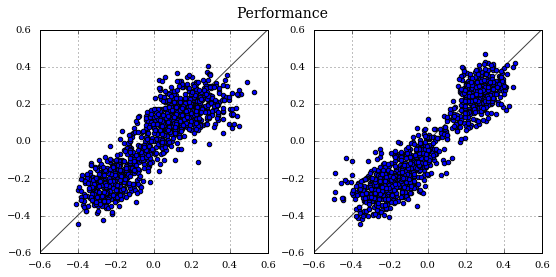

In [105]:
performance_scatter(y_test, preds)

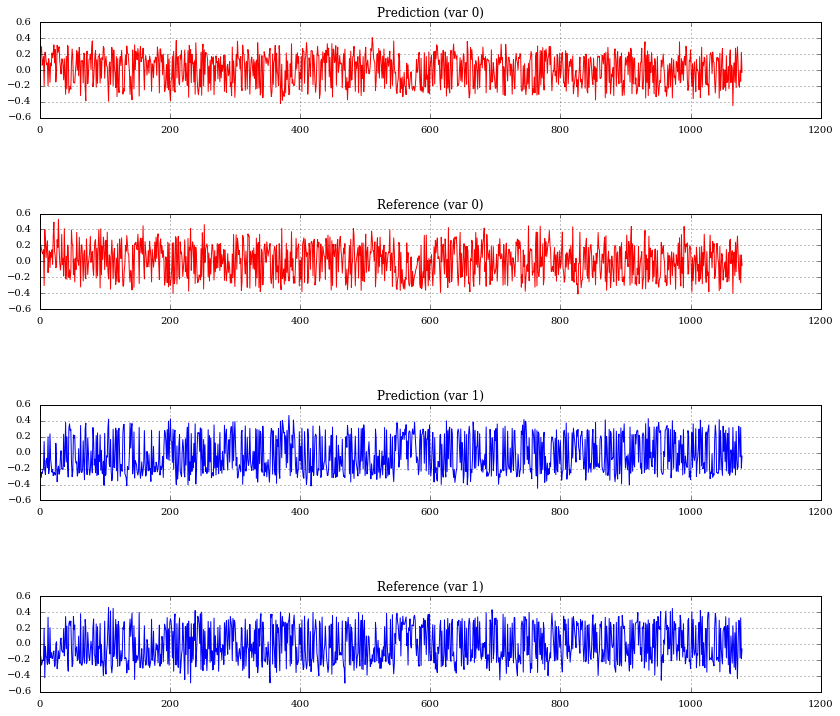

In [106]:
performance_ts(y_test, preds)

In [107]:
print('VARIABLE 0: U COMPONENT')
print(ols_fit_summary(y_test, preds_10_2d, var_num=0))
print('VARIABLE 1: V COMPONENT')
print(ols_fit_summary(y_test, preds_10_2d, var_num=1))

VARIABLE 0: U COMPONENT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     2987.
Date:                Thu, 12 Jul 2018   Prob (F-statistic):          5.87e-313
Time:                        13:55:20   Log-Likelihood:                 892.89
No. Observations:                1080   AIC:                            -1782.
Df Residuals:                    1078   BIC:                            -1772.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0090      0

In [108]:
# Returned as: mae, mse, rmse
print('VARIABLE 0: U COMPONENT')
print(forcast_metrics(x=y_test, y=preds_10_2d, var_num=0))
print('VARIABLE 1: V COMPONENT')
print(forcast_metrics(x=y_test, y=preds_10_2d, var_num=1))

VARIABLE 0: U COMPONENT
(0.08556567189031165, 0.011703233260803235, 0.10818148298485852)
VARIABLE 1: V COMPONENT
(0.07931292840315828, 0.010091186215110716, 0.10045489642178083)


# ConvLSTM2D (1 layer)

In [21]:
#X_train, X_test, y_train, y_test
print(X.shape)

(3270, 201, 394, 2)


In [ ]:
# Find divisors with remainder 0
for i in range(1,50+1):
    if X.shape[0]%i == 0:
        print(i)

In [29]:
# Reshape X into timesteps
#Xx = np.reshape(X, (218, 15, 201, 394, 2))
#print(Xx.shape)

# Add a new axis with length 1 (timestep)
Xx = X[:, np.newaxis, :, :, :]
print(Xx.shape)

(3270, 1, 201, 394, 2)


In [30]:
# Conv LSTM 2D

# Input data in shape (samples, timesteps, y, x, variables)

l2_a= 0.001
model_in = Input(shape=Xx.shape[1:])
opt = Adam()

# Only use 1 layer for now
model = ConvLSTM2D(32, (5, 5), return_sequences=True, activation='relu')(model_in)
print(keras.backend.shape(model))

model = Dropout(0.1)(model)
#model = MaxPooling3D()(model)

# Shape output and compile
model = TimeDistributed(Flatten())(model)
model = TimeDistributed(Dense(2))(model)
#model = Reshape((15,2), input_shape=(30,))(model)

model = Model(model_in, model)
model.compile(opt, loss='mean_squared_error')

Tensor("Shape_2:0", shape=(5,), dtype=int32)


In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 201, 394, 2)    0         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 1, 197, 390, 32)   108928    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 197, 390, 32)   0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 2458560)        0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 2)              4917122   
Total params: 5,026,050
Trainable params: 5,026,050
Non-trainable params: 0
_________________________________________________________________


In [32]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2190, 201, 394, 2)
(2190, 2)
(1080, 201, 394, 2)
(1080, 2)


In [40]:
# Reshape train/test to fit axis dimensions for ConvLSTM

a = X_train[:, np.newaxis, :, :, :]
b = y_train[:, np.newaxis, :]
c = X_test[:, np.newaxis, :, :, :]
d = y_test[:, np.newaxis, :]

print(a.shape)
print(b.shape)
print(c.shape)
print(d.shape)

(2190, 1, 201, 394, 2)
(2190, 1, 2)
(1080, 1, 201, 394, 2)
(1080, 1, 2)


In [52]:
batch_size = 64
epochs = 10
model.fit(a, b,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(c, d))

Train on 2190 samples, validate on 1080 samples
Epoch 1/10
2190/2190 [==============================] - 5357s 2s/step - loss: 0.0144 - val_loss: 0.0118
Epoch 2/10
2190/2190 [==============================] - 5320s 2s/step - loss: 0.0100 - val_loss: 0.0111
Epoch 3/10
2190/2190 [==============================] - 5417s 2s/step - loss: 0.0084 - val_loss: 0.0161
Epoch 4/10
2190/2190 [==============================] - 5309s 2s/step - loss: 0.0079 - val_loss: 0.0108
Epoch 5/10
2190/2190 [==============================] - 5356s 2s/step - loss: 0.0058 - val_loss: 0.0113
Epoch 6/10
2190/2190 [==============================] - 5316s 2s/step - loss: 0.0050 - val_loss: 0.0121
Epoch 7/10
2190/2190 [==============================] - 5322s 2s/step - loss: 0.0045 - val_loss: 0.0120
Epoch 8/10
2190/2190 [==============================] - 5346s 2s/step - loss: 0.0036 - val_loss: 0.0122
Epoch 9/10
2190/2190 [==============================] - 5302s 2s/step - loss: 0.0030 - val_loss: 0.0111
Epoch 10/10
2190

In [53]:
preds_10 = model.predict(c, batch_size=64, verbose=1)
print('done')

1080/1080 [==============================] - 1153s 1s/step
done


In [54]:
preds_10.shape

(1080, 1, 2)

In [55]:
preds_10_2d = np.reshape(preds_10, (1080,2))

In [71]:
np.save('convlstm2d_10epoch_preds.npy', preds_10_2d)

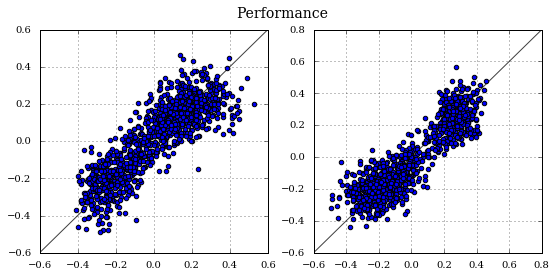

In [60]:
performance_scatter(y_test, preds_10_2d)

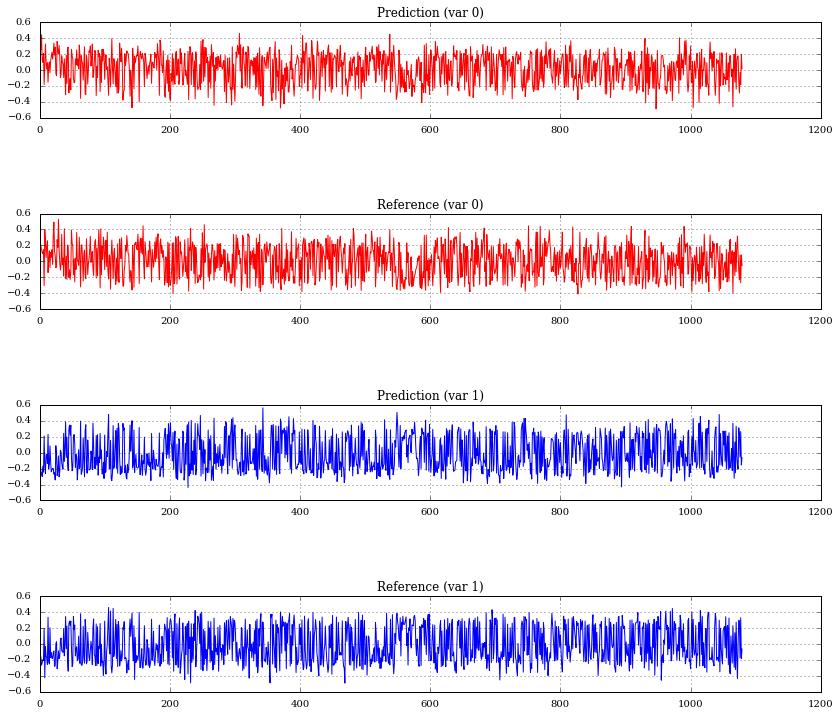

In [61]:
performance_ts(y_test, preds_10_2d)

In [116]:
print('VARIABLE 0: U COMPONENT')
print(ols_fit_summary(y_test, preds_10_2d, var_num=0))
print('-' * 120)
print('VARIABLE 1: V COMPONENT')
print(ols_fit_summary(y_test, preds_10_2d, var_num=1))

VARIABLE 0: U COMPONENT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     2987.
Date:                Thu, 12 Jul 2018   Prob (F-statistic):          5.87e-313
Time:                        14:08:48   Log-Likelihood:                 892.89
No. Observations:                1080   AIC:                            -1782.
Df Residuals:                    1078   BIC:                            -1772.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0090      0

In [69]:
# Returned as: mae, mse, rmse
print('VARIABLE 0: U COMPONENT')
print(forcast_metrics(x=y_test, y=preds_10_2d, var_num=0))
print('VARIABLE 1: V COMPONENT')
print(forcast_metrics(x=y_test, y=preds_10_2d, var_num=1))

VARIABLE 0: U COMPONENT
(0.08556567189031165, 0.011703233260803235, 0.10818148298485852)
VARIABLE 1: V COMPONENT
(0.07931292840315828, 0.010091186215110716, 0.10045489642178083)


# ConvLSTM2D (multi-layer)

In [72]:
print(Xx.shape)

(3270, 1, 201, 394, 2)


In [85]:
# Conv LSTM 2D with multi-layers

# Input data in shape (samples, timesteps, y, x, channels (x and y optical flow motion))

l2_a= 0.001
model_in = Input(shape=Xx.shape[1:])
opt = Adam()

# 1st set of layers

model = ConvLSTM2D(16, (5, 5), return_sequences=True, activation='relu', padding='same', kernel_regularizer=l2(l2_a))(model_in)
model = Dropout(0.1)(model)
model = TimeDistributed(MaxPooling2D())(model)
#model = MaxPooling3D()(model)

# 2nd set of layers
model = ConvLSTM2D(32, (5, 5), return_sequences=True, activation='relu', padding='same', kernel_regularizer=l2(l2_a))(model)
model = Dropout(0.1)(model)
model = TimeDistributed(MaxPooling2D())(model)
#model = MaxPooling3D()(model)

# 3rd set of layers
model = ConvLSTM2D(64, (5, 5), return_sequences=True, activation='relu', padding='same', kernel_regularizer=l2(l2_a))(model)
model = Dropout(0.1)(model)
model = TimeDistributed(MaxPooling2D())(model)
#model = MaxPooling3D()(model)


# Shape output and compile
model = TimeDistributed(Flatten())(model)
model = TimeDistributed(Dense(2))(model)
#model = Reshape((15,2), input_shape=(30,))(model)

model = Model(model_in, model)
model.compile(opt, loss='mean_squared_error')

In [86]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 1, 201, 394, 2)    0         
_________________________________________________________________
conv_lst_m2d_19 (ConvLSTM2D) (None, 1, 201, 394, 16)   28864     
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 201, 394, 16)   0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 1, 100, 197, 16)   0         
_________________________________________________________________
conv_lst_m2d_20 (ConvLSTM2D) (None, 1, 100, 197, 32)   153728    
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 100, 197, 32)   0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 1, 50, 98, 32)     0         
__________

In [87]:
print(a.shape)
print(b.shape)
print(c.shape)
print(d.shape)


(2190, 1, 201, 394, 2)
(2190, 1, 2)
(1080, 1, 201, 394, 2)
(1080, 1, 2)


In [88]:
batch_size = 64
epochs = 10
model.fit(a, b,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(c, d))

Train on 2190 samples, validate on 1080 samples
Epoch 1/10
2190/2190 [==============================] - 5844s 3s/step - loss: 0.0650 - val_loss: 0.0276
Epoch 2/10
2190/2190 [==============================] - 5813s 3s/step - loss: 0.0218 - val_loss: 0.0205
Epoch 3/10
2190/2190 [==============================] - 5832s 3s/step - loss: 0.0173 - val_loss: 0.0172
Epoch 4/10
2190/2190 [==============================] - 5853s 3s/step - loss: 0.0150 - val_loss: 0.0169
Epoch 5/10
2190/2190 [==============================] - 5933s 3s/step - loss: 0.0138 - val_loss: 0.0150
Epoch 6/10
2190/2190 [==============================] - 6018s 3s/step - loss: 0.0130 - val_loss: 0.0151
Epoch 7/10
2190/2190 [==============================] - 5835s 3s/step - loss: 0.0126 - val_loss: 0.0151
Epoch 8/10
2190/2190 [==============================] - 5879s 3s/step - loss: 0.0122 - val_loss: 0.0140
Epoch 9/10
2190/2190 [==============================] - 5820s 3s/step - loss: 0.0118 - val_loss: 0.0141
Epoch 10/10
2190

In [89]:
preds_ml_10 = model.predict(c, batch_size=64, verbose=1)
print('done')

1080/1080 [==============================] - 1391s 1s/step
done


In [90]:
preds_ml_10.shape

(1080, 1, 2)

In [91]:
preds_ml_10 = np.reshape(preds_ml_10, (1080,2))
print(preds_ml_10.shape)

(1080, 2)


In [92]:
np.save('convlstm2d_multilayer_10epoch_preds.npy', preds_ml_10)

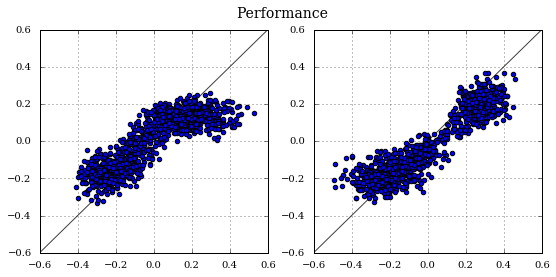

In [93]:
performance_scatter(y_test, preds_ml_10)

In [ ]:
performance_ts(y_test, preds_ml_10)

In [96]:
print('VARIABLE 0: U COMPONENT')
print(ols_fit_summary(y_test, preds_ml_10, var_num=0))
print('VARIABLE 1: V COMPONENT')
print(ols_fit_summary(y_test, preds_ml_10, var_num=1))

VARIABLE 0: U COMPONENT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     3014.
Date:                Thu, 12 Jul 2018   Prob (F-statistic):          1.55e-314
Time:                        11:14:40   Log-Likelihood:                 896.53
No. Observations:                1080   AIC:                            -1789.
Df Residuals:                    1078   BIC:                            -1779.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0165      0

In [97]:
# Returned as: mae, mse, rmse
print('VARIABLE 0: U COMPONENT')
print(forcast_metrics(x=y_test, y=preds_ml_10, var_num=0))
print('VARIABLE 1: V COMPONENT')
print(forcast_metrics(x=y_test, y=preds_ml_10, var_num=1))

VARIABLE 0: U COMPONENT
(0.08869050854902841, 0.012442050928795275, 0.1115439416947208)
VARIABLE 1: V COMPONENT
(0.07661153526631047, 0.009474649123542789, 0.09733780932167514)


# CNN + LSTM layers

In [ ]:
# Next try a combination of Conv2D and LSTM layers?

In [ ]:
# Add another axis (here, 5th)
Xx = np.expand_dims(X, 4)

# All results comparison

In [167]:
# Load model predictions from saved files
# Model 1: Conv2D (multi layer set)
p1 =  np.load('cnn_10epoch_preds.npy')
# Model 2: ConvLSTM2D (single layer set)
p2 = np.load('convlstm2d_10epoch_preds.npy')
# Model 3: ConvLSTM2D (multi layer set)
p3 = np.load('convlstm2d_multilayer_10epoch_preds.npy')

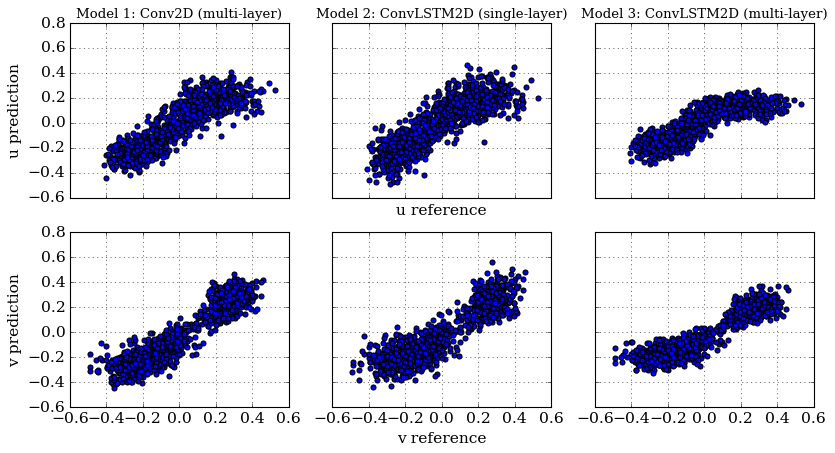

In [202]:
# Model comparison, with both variables together

f, axarr = plt.subplots(2,3, figsize=(12,6), sharex=True, sharey=True)
axarr[0][0].scatter(y_test[:,0], p1[:,0])
axarr[1][0].scatter(y_test[:,1], p1[:,1])
axarr[0][0].set_title('Model 1: Conv2D (multi-layer)', fontsize=12)

axarr[0][1].scatter(y_test[:,0], p2[:,0])
axarr[1][1].scatter(y_test[:,1], p2[:,1])
axarr[0][1].set_title('Model 2: ConvLSTM2D (single-layer)', fontsize=12)

axarr[0][2].scatter(y_test[:,0], p3[:,0])
axarr[1][2].scatter(y_test[:,1], p3[:,1])
axarr[0][2].set_title('Model 3: ConvLSTM2D (multi-layer)', fontsize=12)

axarr[0][1].set_xlabel('u reference')
axarr[1][1].set_xlabel('v reference')
axarr[0][0].set_ylabel('u prediction')
axarr[1][0].set_ylabel('v prediction')

plt.savefig('keras_model_comparison.png')